In [320]:
# !pip install lifelines

In [321]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import math
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd    
import seaborn as sns
from IPython.display import Markdown, display
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib.colors import ListedColormap

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

sns.set_style("whitegrid")

In [480]:
# Utility functions

def print_header(title):
    """
    Prints a header with a given title.

    Parameters:
    title (str): The title to print.
    """
    print("-" * 60)
    print(title)
    print("-" * 60)

def inspect_missing_values(df):
    """
    Generate a DataFrame that provides information about missing values in the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.
    columns (list): The list of columns in the DataFrame to analyze.

    Returns:
    pandas.DataFrame: A DataFrame where each column corresponds to a column in the original DataFrame,
                      and each row provides information about the total number of values, the percentage of missing values,
                      and the data type of that column.
    """
    index_names = ["Total", "Missing %", "Data type"]
    columns = df.columns
    missing_values_table = pd.DataFrame(index=index_names, columns=columns)
    for col in columns:
        missing_data = df[col].isnull().sum()
        missing_data_percentage = round((missing_data/df.shape[0])*100, 2)
        missing_values_table.loc[index_names[0],col] = df[col].isnull().sum()
        missing_values_table.loc[index_names[1],col] = missing_data_percentage
        missing_values_table.loc[index_names[2],col] = df[col].dtype
    return missing_values_table

def inspect_frequent_values(df):
    """
    Generate a DataFrame that provides information about the most frequent values in the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.
    columns (list): The list of columns in the DataFrame to analyze.

    Returns:
    pandas.DataFrame: A DataFrame where each column corresponds to a column in the original DataFrame,
                      and each row provides information about the total number of values, the most frequent value,
                      the count of the most frequent value, and the percentage of the most frequent value.
    """   
    index_names = ["Total", "Freq", "Count", "Freq %"]
    columns = df.columns
    most_frequent_table = pd.DataFrame(index=index_names, columns=columns)
    for col in columns:
        most_frequent_table.loc[index_names[0],col] = df[col].count()
        most_frequent_table.loc[index_names[1],col] = df[col].mode()[0]  
        most_frequent_table.loc[index_names[2],col] = df[col].value_counts().max()
        most_frequent_table.loc[index_names[3],col] = round((df[col].value_counts().max()/df[col].count())*100, 2)

    return most_frequent_table

def inspect_unique_values(df):
    """
    Inspect the unique values in the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.

    Returns:
    pandas.DataFrame: A DataFrame where each column corresponds to a column in the original DataFrame,
                      and each row provides information about the number of unique values.
    """
    unique_values_table = pd.DataFrame(index=["Unique", "Total"], columns=df.columns)
    for col in df.columns:
        unique_values_table.loc["Count",col] = len(df[col])
        unique_values_table.loc["Unique",col] = df[col].nunique()       
    return unique_values_table

def display_custom_palette(colors):
    custom_cmap = ListedColormap(colors)
    print("Custom Color Palette Display:")
    sns.palplot(sns.color_palette(colors))
    plt.show()

palette_colors = ["#FF40D1", "#19D4FF", "#ACF626", "#049DD9", "#F27B35"]


<style>
code, kbd, pre, samp {
    /*font-family:'consolas', Lucida Console, SimSun, Fira Code, Monaco !important;*/
    font-size: 11pt !important;
}

div.output_area pre {
    font-family: 'consolas', Lucida Console, SimSun, Fira Code, Monaco !important;
    font-size:  10pt !important;
}

div.output_area img, div.output_area svg {
    background-color: #FFFFFF !important;
}
</style>

<font size=5>EDA & Vintage Analysis</font>

[Xiao Song](https://xsong.ltd/en)

For chinese reader, hope you check my wechat official account article: [信用评分模型中的Vintage分析](https://mp.weixin.qq.com/s/peb3XhXLCSTQYOa5e6u6TQ). 

Vintage analysis is a widely-used method for managing credit risk, it illustrate the behavior after an account was opened. Based on same origination period, it calculates charge-off ratio of a loan portfolio. 






Here comes our datasets, in which `credit_record.csv` contains loan accounts' credit records, the detailed data explanation is here:

|  credit_record.csv           | 　                        | 　                                                                                                                                                                                                                            |
|:-----------------------:|---------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Feature name          | Explanation               | Remarks                                                                                                                                                                                                                       |
| ID                    | Client number             | 　                                                                                                                                                                                                                            |
| MONTHS_BALANCE        | Record month              | The month of the extracted data is the starting point,  backwards, 0 is the current month, -1 is the previous month,  and so on                                                                                               |
| STATUS               | Status                    | 0: 1-29 days past due 1: 30-59 days past due   2: 60-89 days overdue 3: 90-119 days overdue    4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days    C: paid off that month X: No loan for the month  |



-----



while the `application_record.csv` contains appliers' features, such as gender, income. This notebook will show some necessary EDA on credit_record table.

# Credit Card Approval Prediction

A Credit Card Dataset for Machine Learning


## Application records table

The `application_record.csv` dataset provides a comprehensive overview of client applications for financial services. It includes personal, financial, and employment information that can be used to assess creditworthiness. Each entry represents a unique client identified by a number and includes various attributes that can be leveraged to predict potential loan repayment behaviors.

- **ID**: Unique identifier for each client.
- **CODE_GENDER**: Gender of the client.
- **FLAG_OWN_CAR**: Whether the client owns a car.
- **FLAG_OWN_REALTY**: Whether the client owns property.
- **CNT_CHILDREN**: The number of children the client has.
- **AMT_INCOME_TOTAL**: The total annual income of the client.
- **NAME_INCOME_TYPE**: The category of the client's income source.
- **NAME_EDUCATION_TYPE**: The highest education level the client has achieved.
- **NAME_FAMILY_STATUS**: The marital status of the client.
- **NAME_HOUSING_TYPE**: The client's living situation.
- **DAYS_BIRTH**: The client's age in days, counted backwards from the current day.
- **DAYS_EMPLOYED**: How long the client has been employed, counted backwards from the current day. Positive numbers indicate unemployment.
- **FLAG_MOBIL**: Whether the client owns a mobile phone.
- **FLAG_WORK_PHONE**: Whether the client has a work phone.
- **FLAG_PHONE**: Whether the client has a phone.
- **FLAG_EMAIL**: Whether the client has an email address.
- **OCCUPATION_TYPE**: The client's occupation.
- **CNT_FAM_MEMBERS**: The size of the client's family.

In [322]:
application_raw = pd.read_csv('../data/raw/application_record.csv') 
application = application_raw.copy()
application

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


#### Are Application Record IDs unique?


In [476]:
Markdown(
        f"**Unique IDs:** {application['ID'].nunique()}<br>"
        f"**Num Rows:** {application.shape[0]}"
        )

**Unique IDs:** 438510<br>**Num Rows:** 438557

#### Removing duplicated IDs

In [479]:
application = application_raw.drop_duplicates(subset='ID', keep='first')
Markdown(
        f"**Unique IDs:** {application['ID'].nunique()}<br>"
        f"**Num Rows:** {application.shape[0]}"
        )
# application.to_csv('../data/processed/application_record_no_duplicates.csv', index=False)

**Unique IDs:** 438510<br>**Num Rows:** 438510

#### Frequent Values

In [484]:
inspect_frequent_values(application)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
Total,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,304317,438510
Freq,5008804,F,N,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11707,365243,1,0,0,0,Laborers,2.0
Count,1,294406,275427,304040,304040,46875,226076,301788,299798,393791,150,75324,438510,348121,312320,391063,78231,233870
Freq %,0.0,67.14,62.81,69.33,69.33,10.69,51.56,68.82,68.37,89.8,0.03,17.18,100.0,79.39,71.22,89.18,25.71,53.33


### Credit Record Table

**MONTHS_BALANCE**

This is a backwards-looking calendar for each client's financial records. The MONTHS_BALANCE is the time reference for the data, where 0 is the current month, -1 is the previous month, -2 is two months back, and so on. It's useful for tracking how a client's status has changed over time.

**STATUS**  

The STATUS column is a quick snapshot of a client's loan repayment behavior for the corresponding month in MONTHS_BALANCE. It ranges from 0 to 5, with 0 indicating 1-29 days past due, and 5 indicating serious delinquency (overdue or bad debts, write-offs for more than 150 days). Additionally, C means the debt was paid off that month, and X indicates there was no loan for the month.

- 0: 1-29 days past due
- 1: 30-59 days past due
- 2: 60-89 days overdue
- 3: 90-119 days overdue
- 4: 120-149 days overdue
- 5: Overdue or bad debts, write-offs for more than 150 days
- C: paid off that month
- X: No loan for the month

In [481]:
credit_raw = pd.read_csv('../data/raw/credit_record.csv')
credit = credit_raw.copy()
credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


#### Credit Record IDs

In [483]:
Markdown(
        f"**Unique IDs:** {credit['ID'].nunique()}<br>"
        f"**Num Rows:** {credit.shape[0]}"
        )

**Unique IDs:** 45985<br>**Num Rows:** 1048575

#### Shared IDs

In [364]:
n_shared_ids = len(set(application['ID']).intersection(set(credit['ID'])))
Markdown(f"**Shared IDs between the 2 tables:** {n_shared_ids}")

**Shared IDs between the 2 tables:** 36457

# Vintage Analysis

Detailed explanation could be seen here [here](https://www.listendata.com/2019/09/credit-risk-vintage-analysis.html). 

In [365]:
grouped = credit.groupby('ID')

### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, end of observe window or end of loan
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe `window` of each ID
pivot_tb.reset_index(drop = True, inplace = True)  # reset index
pivot_tb

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [366]:
# Joining "open_month", "end_month", "window" to the credit table
credit = pd.merge(credit_raw, pivot_tb, on = 'ID', how = 'left')
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,29
1048571,5150487,-26,C,-29,0,29
1048572,5150487,-27,C,-29,0,29
1048573,5150487,-28,C,-29,0,29


In [367]:
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20

In [368]:
# Create a new column to indicate whether the loan is default
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not

In [369]:
'''
def countplot(df, col, group_by=None, ax=None):

    ax = sns.countplot(x=col, data=df, hue=group_by, ax=ax)
    ax.set_title(f'{col.capitalize()} Countplot')
    if group_by:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(left=False, bottom=False)

    # Calculate total counts and percentages
    total_counts = df[col].value_counts().sum()

    # Set y-axis ticks distance
    # ax.yaxis.set_major_locator(MultipleLocator(500))

    # Add values to each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  
            percentage = 100 * height / total_counts
            ax.annotate(f'{percentage:.0f}%',
                        (p.get_x() + p.get_width() / 2., p.get_height()),  # top
                        ha='center', va='center',
                        xytext=(0, -12),
                        color='white',
                        fontsize=12,
                        textcoords='offset points',
                        )

    # Add headroom by increasing the y-axis limit
    # ax.set_ylim(0, max([p.get_height() for p in ax.patches]) * 1.1)

    plt.show()

countplot(credit, "status")
# sns.countplot(x="status", data=credit, hue=None, ax=None)

'''

'\ndef countplot(df, col, group_by=None, ax=None):\n\n    ax = sns.countplot(x=col, data=df, hue=group_by, ax=ax)\n    ax.set_title(f\'{col.capitalize()} Countplot\')\n    if group_by:\n        ax.legend_.remove()\n    ax.set_xlabel(\'\')\n    ax.set_ylabel(\'\')\n    ax.tick_params(left=False, bottom=False)\n\n    # Calculate total counts and percentages\n    total_counts = df[col].value_counts().sum()\n\n    # Set y-axis ticks distance\n    # ax.yaxis.set_major_locator(MultipleLocator(500))\n\n    # Add values to each bar\n    for p in ax.patches:\n        height = p.get_height()\n        if height > 0:  \n            percentage = 100 * height / total_counts\n            ax.annotate(f\'{percentage:.0f}%\',\n                        (p.get_x() + p.get_width() / 2., p.get_height()),  # top\n                        ha=\'center\', va=\'center\',\n                        xytext=(0, -12),\n                        color=\'white\',\n                        fontsize=12,\n                      

In [370]:
count = credit['status'].value_counts()
percentage = credit['status'].value_counts(normalize=True) * 100
pd.DataFrame({'Count': count, 'Percentage': percentage}).style.set_caption("<h3> Default Status Count and Percentage")
# credit.to_csv('../data/processed/credit_record_with_windows.csv', index=False)

,Count,Percentage
status,,
0,772745,99.672764
1,2537,0.327236


In [371]:
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,status,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4
...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25
1048548,5150487,-3,C,-29,0,29,0,26
1048547,5150487,-2,C,-29,0,29,0,27
1048546,5150487,-1,C,-29,0,29,0,28


In [372]:
# denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']
denominator.head(10)

,open_month,sta_sum
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
5,-55,486
6,-54,468
7,-53,493
8,-52,553
9,-51,582


In [373]:
# vintage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum']
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete sta_sum column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [374]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()

vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


Using `pivot` to convert long data to wide data:

In [375]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,Na

This is a standard vingtage analysis table. The rows represent months of opening accounts, columns represent months after openning acounts, and values are accumlate past-due rate. As open-month closes to 0, the observe window shortens, thus the bottom half triangular field is filled by nan.

In [376]:
vintage0.head(10)

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,NaN,NaN,NaN,NaN,NaN,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,NaN,NaN,NaN,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,NaN,NaN,NaN,NaN,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,NaN,NaN,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,NaN,NaN,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,NaN,NaN,NaN,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,NaN,0.002028,0.002028,0.002028,0.004057,0.004057,0.008114,0.010142,0.010142,0.012170,0.014199,0.01419

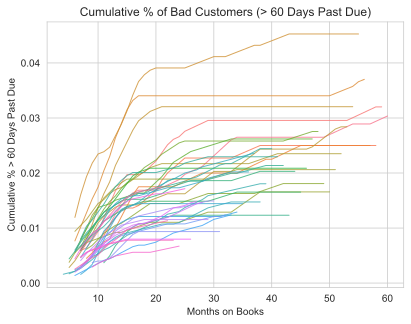

In [377]:
# plot vintage line chart
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
# sns.lineplot(data=vintage0[lst], legend=False, linewidth=1, dashes=False, alpha=0.4)
# sns.lineplot(data=vintage0[lst].T, legend=False, palette='viridis', linewidth=2, dashes=False, alpha=0.4)
sns.lineplot(data=vintage0[lst].T.rolling(window=5).mean(), legend=False, linewidth=1, dashes=False, alpha=.8)
plt.title('Cumulative % of Bad Customers (> 60 Days Past Due)')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.grid(True)
plt.show()

# Observe Window Analysis

Because of two reasons, account cancellation and observe over, our observe on accounts will be truncated. Observe window is a significant parameter to be considered. If observe window is too short, users' behavior will not fully show off, which will bring unnecessary noise to our data.

In order to observe how many accounts increase as observe window extend, we plot this. 

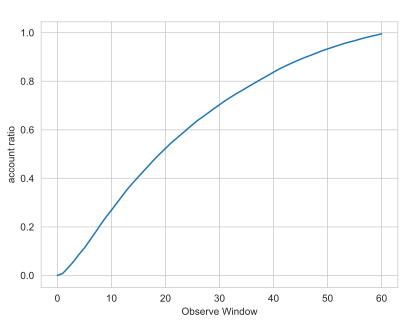

In [378]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

We could see that a 60 months observe window covers all appliers, while 20 months window contains about 52% records.

In [379]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

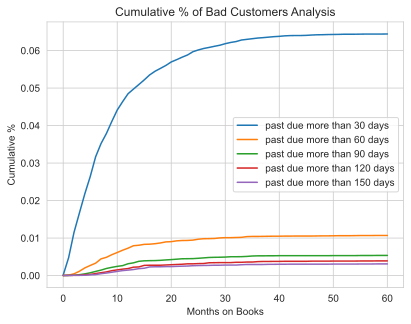

In [380]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

This plot could be seen as a average (across open-month) version of vintage plot.
For longer past due date, it needs longer observe window. For example, more than 150 days past due needs at least 5 months until first *bad customer* appears. For most situation, a 20-months observe window could cover most *bad customer*. However, For 30 days past due, we could see that after 30 months on books, there still are new *bad customer* join in the list. So a 20 MOB observe window will be appropriate. Those who exists shorter than the observe window should be excluded from our analysis, thus you could see I deleted users whose observe window less than 20 on last section (the window could be changed).

# Overall Past-due Ratio

Calculating overall past-due rate. Respectively, we analyze 1 day past due, 20 days past due, 60 days past due, 90 days past due, 120 days past due, 150 days past due. This analysis could help us to define who are *bad customers*. We could see that almost 87% users have past due more than 1 day, which is too common, thus it's inappropriate to be a standard. What about 150 days overdue? Only 0.4% of accounts appear to past due that long. If we use that, we will left many *bad customers* in our scrutiny. A table like that will help you to determine what  will be the most suitable standard of *bad customers*.

In [381]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


# Summary

Here shows some EDA on credit_record table, including vintage analysis, bad customer definition and observe window analysis. For credit card application data analysis, the response variable sometimes not clear, thus we need to extract information from credit record. This notebook does not contain all possible methods for sure. There definitly has more methods, I expect more valuable analysis based on this data :)

# Survival Analysis

In [382]:
credit['truncate'] = credit.groupby('ID')['status'].transform('max')

In [383]:
truncate = credit.loc[credit['truncate']==1,]
not_trunc = credit.loc[credit['truncate']==0,]

In [400]:
dt1 = not_trunc.groupby('ID').agg({'month_on_book': ['max'],
                            'truncate':['max']
                           })
dt1.reset_index(inplace = True)
dt1.columns = ['ID','month_on_book','truncate']
dt1.head(10)


,ID,month_on_book,truncate
0,5001713,21,0
1,5001715,59,0
2,5001717,21,0
3,5001718,38,0
4,5001719,42,0
5,5001720,35,0
6,5001723,30,0
7,5001724,30,0
8,5001726,38,0
9,5001730,60,0


In [402]:
dt2 = truncate.loc[truncate['status']==1,].groupby('ID').agg({'month_on_book': ['min'],
                            'truncate':['max']
                           })
dt2.reset_index(inplace = True)
dt2.columns = ['ID','month_on_book','truncate']
dt2.head(10)

,ID,month_on_book,truncate
0,5003804,12,1
1,5004559,7,1
2,5005205,58,1
3,5008827,14,1
4,5009628,24,1
5,5009746,9,1
6,5009752,9,1
7,5009753,9,1
8,5009754,9,1
9,5010864,14,1


In [407]:
dt = pd.concat([dt1, dt2])
dt.head(10)

,ID,month_on_book,truncate
0,5001713,21,0
1,5001715,59,0
2,5001717,21,0
3,5001718,38,0
4,5001719,42,0
5,5001720,35,0
6,5001723,30,0
7,5001724,30,0
8,5001726,38,0
9,5001730,60,0


<Axes: xlabel='timeline'>

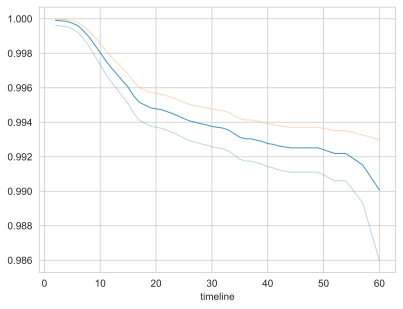

In [470]:
kmf = KaplanMeierFitter()
kmf.fit(dt['month_on_book'], event_observed=dt['truncate'], label='overdue')
kmf.event_table.head(10)
# sns.lineplot(data=vintage0[lst].T.rolling(window=5).mean(), legend=False, linewidth=1, dashes=False, alpha=.8)
# sns.scatterplot(data=kmf.event_table, legend=False, linewidth=1, alpha=.8)
sns.lineplot(data=kmf.survival_function_.rolling(window=3).mean(), legend=False, linewidth=1, alpha=.8)
sns.lineplot(data=kmf.confidence_interval_.rolling(window=3).mean(), legend=False, linewidth=1, dashes=False, alpha=.3)
# sns.lineplot(data=pd.concat([kmf.survival_function_, kmf.confidence_interval_]).rolling(window=3).mean(), legend=False, linewidth=1, alpha=.8)
# kmf.plot()


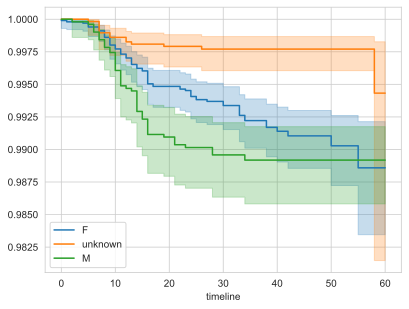

In [471]:
application = application[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
dt = pd.merge(dt, application, on = 'ID', how = 'left')
dt.fillna('unknown',inplace=True)

def plot_km(dt, timevar, truncate, groupby):
    '''plot km by subgroup
    '''
    plt.rcParams['figure.facecolor'] = 'white'
    kmf = KaplanMeierFitter()
    t = np.linspace(0, 60, 61)
    for i in dt[groupby].value_counts().index:
        kmf.fit(dt[dt[groupby] == i][timevar], event_observed=dt[dt[groupby] == i][truncate], timeline=t, label=i)
        ax = kmf.plot()

plot_km(dt, 'month_on_book', 'truncate', 'CODE_GENDER')

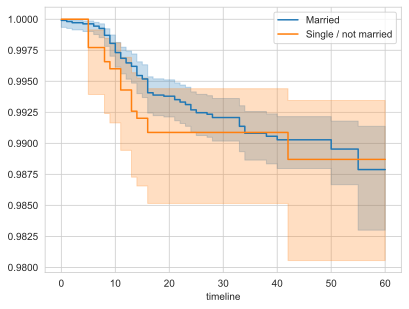

In [472]:
kmf = KaplanMeierFitter()
t = np.linspace(0, 60, 61)
kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Married']['truncate'], timeline=t, label="Married")
ax = kmf.plot()

kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['truncate'], timeline=t, label="Single / not married")
ax = kmf.plot()